# BraTs2015 dataset Test

In [1]:
import SimpleITK as sitk
import skimage.io as io

mha_path = 'BRATS2015_Training/HGG/brats_tcia_pat153_0109/VSD.Brain.XX.O.MR_T1.40842/VSD.Brain.XX.O.MR_T1.40842.mha'
nii_path = 'test/VSD.Brain.XX.O.MR_T1.40842.nii.gz'
# nii_path = 'test/VSD.Brain.XX.O.MR_Flair.35533.nii'

reader = sitk.ImageFileReader()
reader.SetImageIO("MetaImageIO")
reader.SetFileName(mha_path)
image = reader.Execute()

writer = sitk.ImageFileWriter()
writer.SetFileName(nii_path)
writer.Execute(image)

In [2]:
import sys
from matplotlib import gridspec
print(sys.version_info) # pythonのversion確認
import numpy as np
import matplotlib.pyplot as plt # 描画用
import scipy.interpolate as interpolate
import nibabel as nib # NiBabelの導入の確認　エラーが出なければ成功

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)


(240, 240, 155)


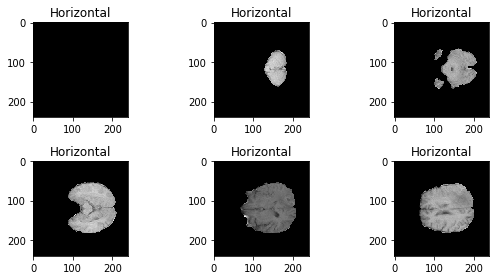

In [3]:
img = nib.load(nii_path)
img_data = img.get_fdata()
print(img_data.shape)

# plot
gs = gridspec.GridSpec(2, 3, width_ratios=[1.17, 1, 1.17])
plt.figure(figsize=(8,4))
"""
plt.subplot(gs[0])
plt.title("Sagittal")
plt.imshow(np.flipud(img_data[28].T), cmap="gray")

plt.subplot(gs[1])
plt.title("Coronal")
plt.imshow(np.flipud(img_data[:, 33].T), cmap="gray")
"""

for i in range(6):
    plt.subplot(gs[i])
    plt.title("Horizontal")
    plt.imshow(img_data[:, :, i*20], cmap="gray")
plt.tight_layout()
plt.show()

(240, 240, 155)


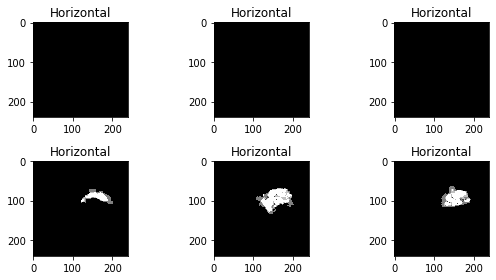

In [4]:
gt_path = 'test/VSD.Brain_3more.XX.O.OT.42293.nii.gz'

gt_img = nib.load(gt_path)
gt_img_data = gt_img.get_fdata()
print(gt_img_data.shape)

gs = gridspec.GridSpec(2, 3, width_ratios=[1.17, 1, 1.17])
plt.figure(figsize=(8,4))

for i in range(6):
    plt.subplot(gs[i])
    plt.title("Horizontal")
    plt.imshow(gt_img_data[:, :, i*20], cmap="gray")
plt.tight_layout()
plt.show()

In [5]:
import SimpleITK as sitk
import os

import numpy
import matplotlib
import os

%matplotlib inline
matplotlib.rcParams.update({'font.size': 24})
import matplotlib.pyplot as plt

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [6]:
data_path = 'BRATS2015_Training/HGG/'
flairs = []
segs = []

for root, dir, files in os.walk(data_path):
    for f in files:
        if 'Flair' in f:
            flairs.append(root + '/' + f)
        if '.OT' in f:
            segs.append(root + '/' + f)
flairs = sorted(flairs)
segs = sorted(segs)

BRATS2015_Training/HGG/brats_tcia_pat105_0001/VSD.Brain.XX.O.MR_Flair.35533/VSD.Brain.XX.O.MR_Flair.35533.mha
BRATS2015_Training/HGG/brats_tcia_pat105_0001/VSD.Brain_3more.XX.O.OT.42283/VSD.Brain_3more.XX.O.OT.42283.mha
(155, 240, 240)
(155, 240, 240)


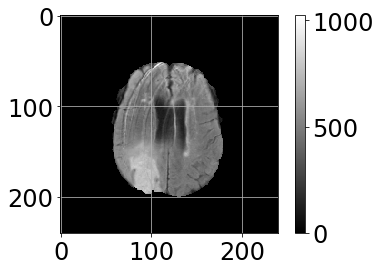

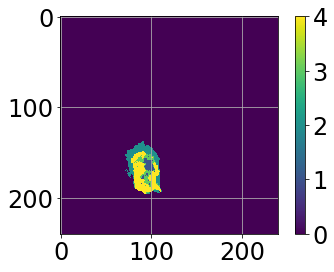

In [7]:

SLICE = 90
IMAGE_NUMBER = 20

print(flairs[IMAGE_NUMBER])
print(segs[IMAGE_NUMBER])

im1 = sitk.GetArrayFromImage(sitk.ReadImage(flairs[IMAGE_NUMBER]))
im2 = sitk.GetArrayFromImage(sitk.ReadImage(segs[IMAGE_NUMBER]))

print(im1.shape)
print(im2.shape)

plt.figure()
plt.grid('off')
plt.imshow(im1[SLICE,:,:], cmap = 'gray')
plt.colorbar()
plt.show()

plt.figure()
plt.grid('off')
plt.imshow(im2[SLICE,:,:])
plt.colorbar()
plt.show()

In [8]:
def process_image_seg(image,segmentation,crop=128):
    image = image.astype(float)
    image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
    
    N,H,W = image.shape
    
    x = image[:,H//2-crop//2:H//2+crop//2,W//2-crop//2:W//2+crop//2]
    y = segmentation[:,H//2-crop//2:H//2+crop//2,W//2-crop//2:W//2+crop//2]
    
    return x,y

def split_positive_negative(images,segmentations):
    negative_index = np.where(np.sum(segmentations,axis=(1,2))<1)
    positive_index = np.where(np.sum(segmentations,axis=(1,2))>=1)
    
    X_negative = images[negative_index]
    Y_negative = segmentations[negative_index]
    
    X_positive = images[positive_index]
    Y_positive = segmentations[positive_index]
    
    return X_positive,Y_positive,X_negative,Y_negative

In [9]:
def make_dataset(f,flairs,segs):
    i_positive = 0
    i_negative = 0
    
    X_p = f.create_dataset("X_positive", (100000, CROP_DIMS,CROP_DIMS), 
                           maxshape=(None, CROP_DIMS,CROP_DIMS))
    Y_p = f.create_dataset("Y_positive", (100000, CROP_DIMS,CROP_DIMS), 
                           maxshape=(None, CROP_DIMS,CROP_DIMS))
    X_n = f.create_dataset("X_negative", (100000, CROP_DIMS,CROP_DIMS), 
                           maxshape=(None, CROP_DIMS,CROP_DIMS))
    Y_n = f.create_dataset("Y_negative", (100000, CROP_DIMS,CROP_DIMS), 
                           maxshape=(None, CROP_DIMS,CROP_DIMS))

    for flair_file,seg_file in zip(flairs,segs):
        im1 = sitk.GetArrayFromImage(sitk.ReadImage(flair_file))
        im2 = sitk.GetArrayFromImage(sitk.ReadImage(seg_file))

        x_processed,y_processed = process_image_seg(im1,im2,CROP_DIMS)

        x_positive,y_positive,x_negative,y_negative = split_positive_negative(x_processed, y_processed)

        n_positive = len(x_positive)
        n_negative = len(x_negative)

        X_p[i_positive:i_positive+n_positive] = x_positive
        Y_p[i_positive:i_positive+n_positive] = y_positive

        X_n[i_negative:i_negative+n_negative] = x_negative
        Y_n[i_negative:i_negative+n_negative] = y_negative

        i_positive = i_positive + n_positive
        i_negative = i_negative + n_negative

        
    X_p.resize(i_positive,axis=0)
    Y_p.resize(i_positive,axis=0)
    X_n.resize(i_negative,axis=0)
    Y_n.resize(i_negative,axis=0)
    print('found {} positive examples and {} negative examples'.format(i_positive,i_negative))

In [11]:
import h5py

CROP_DIMS = 128

f_train = h5py.File('brats_train.h5','w')
f_test = h5py.File('brats_test.h5','w')

make_dataset(f_train,flairs[:-20],segs[:-20])
make_dataset(f_test,flairs[-20:],segs[-20:])

f_train.close()
f_test.close()

#with h5py.File('brats_train.h5', 'w') as f_train:
#    make_dataset(f_train, flairs[:-20], segs[:-20])

found 14622 positive examples and 16378 negative examples
found 1474 positive examples and 1626 negative examples
